In [1]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn import linear_model
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import networkx as nx
from random import shuffle
import itertools
from networkx.algorithms import bipartite

DATA_FOLDER = "/Users/karunya/Documents/EPFL/ADA/ADA_Group_Tota_Pasari_Prelot/04 - Applied ML/"

pd.options.mode.chained_assignment = None

/Users/karunya/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# import csv data into a dataframe
file = glob.glob(DATA_FOLDER + "lalonde.csv")
df = pd.read_csv(file[0])
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


## Question 1: Propensity score matching

### 1. A naive analysis
#### Compare the distribution of the outcome variable (re78) between the two groups (if subject participated in job training or not), using plots and numbers. To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

#### What might a naive "researcher" conclude from this superficial analysis?

Let's try to look at the dataset

In [3]:
df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


We observe below that there is no null values

In [4]:
df.isnull().any()

id          False
treat       False
age         False
educ        False
black       False
hispan      False
married     False
nodegree    False
re74        False
re75        False
re78        False
dtype: bool

Let's look at the distribution of the variable of interest


Split the datasets into treated and untreated dataframes.

In [5]:
treated = df[df['treat'] == 1]
untreated = df[df['treat'] == 0]treated.describe()untreated.describe()#### Initial Conclusions: 
By considering these numbers, we can form a naive analysis of the 're78' group between both datasets. It is evident that the max salary is higher for the treated group (60,307) than the untreated group (25,564). However, the mean is slightly higher in the untreated group by roughly 635. But the untreated group (the number of participants without a training program) is much higher.# plot the treated group's earnings in 1978
plt.figure()
plt.xlabel('1978 Earnings ($)')
plt.ylabel('Count')
plt.title('Treated Group: Real Earnings in 1978 Distribution')
plt.hist(treated['re78'])
plt.show()

# plot the control group's earnings in 1978
plt.figure()
plt.xlabel('1978 Earnings ($)')
plt.ylabel('Count')
plt.title('Untreated Group: Real Earnings in 1978 Distribution')
plt.hist(untreated['re78'])
plt.show()By looking at the histograms of the 1978 earnings for both groups, we see that there is a larger number of people earning 0 to 5000 in the untreated group than in the treated group. This can naively cause us to assume that the training program worked.Now, let's see if our data fits any particular distributions such as the Power distribution. We can check if this fits the Power distribution because it is important to observe the frequencies of salaries in the datasets.# check if the treated and untreated datasets fits the power distribution
sns.distplot(treated['re78'], fit=stats.powerlaw, kde=False)
plt.title('Treated Group: Real Earnings 1978 distribution with Power Law Fit',fontsize=14)
plt.show()

sns.distplot(untreated['re78'], fit=stats.powerlaw, kde=False)
plt.title('Untreated Group: Real Earnings 1978 distribution with Power Law Fit',fontsize=14)
plt.show()

# plot the Q-Q plots to see if there is a relationship
stats.probplot(treated['re78'], dist=stats.powerlaw, sparams=(0.8),plot=plt)
plt.title("Treated Group: Power Law Q-Q plot", fontsize=14)
plt.xlabel('Theoritical Quantiles', fontsize=14)
plt.ylabel('Ordered Values Real Earnings 78', fontsize=14)
plt.show()

stats.probplot(untreated['re78'], dist=stats.powerlaw, sparams=(0.8),plot=plt)
plt.title("Untreated Group: Power Law Q-Q plot", fontsize=14)
plt.xlabel('Theoritical Quantiles', fontsize=14)
plt.ylabel('Ordered Values Real Unearnings 78', fontsize=14)
plt.show()From these plots, it is difficult to analyze these distributions because the Q-Q plots have many outliers.Overall, we have made several naive conclusions from observing the numbers and distributions of the dataset. We have observed that the max salary is higher for the treated group and the number of people earning low income is high in the untreated group. These observations lead us to naively believe that the training program worked.Let's consider the distributions in the treated group and control groups first for the categorical features ('race', 'marriage status', and 'degree received or not') in the dataset first by using box plots.categorical_features = ['black', 'hispan', 'married', 'nodegree']

# create each box plot for each feature vs re78
for ft in categorical_features:
    sns.boxplot(x=ft, y="re78", data=treated)
    plt.title('Treated Group')
    plt.xlabel('Feature: ' + ft)
    plt.ylabel('Real Earnings 1978 ($)')
    plt.show()
    
    sns.boxplot(x=ft, y="re78", data=untreated)
    plt.title('Untreated Group')
    plt.xlabel('Feature: ' + ft)
    plt.ylabel('Real Earnings 1978 ($)')
    plt.show()Now let's consider the features with continuous values using scatter plots:

In [6]:
treated.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [7]:
untreated.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


#### Initial Conclusions: 
By considering these numbers, we can form a naive analysis of the 're78' group between both datasets. It is evident that the max salary is higher for the treated group (60,307) than the untreated group (25,564). However, the mean is slightly higher in the untreated group by roughly 635. But the untreated group (the number of participants without a training program) is much higher.

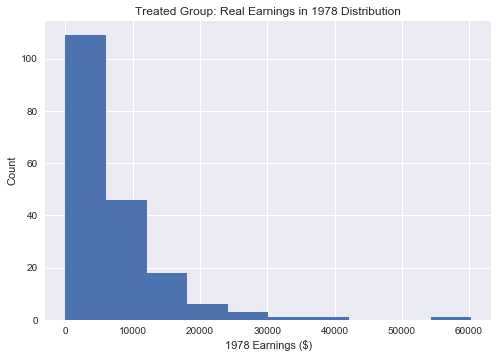

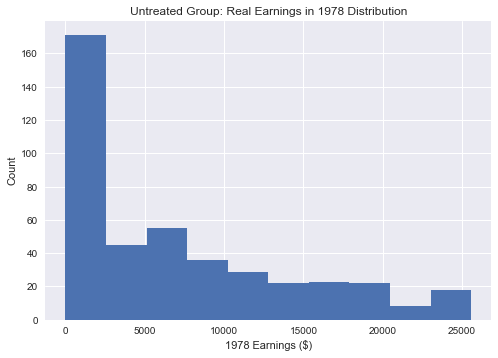

In [8]:
# plot the treated group's earnings in 1978
plt.figure()
plt.xlabel('1978 Earnings ($)')
plt.ylabel('Count')
plt.title('Treated Group: Real Earnings in 1978 Distribution')
plt.hist(treated['re78'])
plt.show()

# plot the control group's earnings in 1978
plt.figure()
plt.xlabel('1978 Earnings ($)')
plt.ylabel('Count')
plt.title('Untreated Group: Real Earnings in 1978 Distribution')
plt.hist(untreated['re78'])
plt.show()

By looking at the histograms of the 1978 earnings for both groups, we see that there is a larger number of people earning 0 to 5000 in the untreated group than in the treated group. This can naively cause us to assume that the training program worked.

Now, let's see if our data fits any particular distributions such as the Power distribution. We can check if this fits the Power distribution because it is important to observe the frequencies of salaries in the datasets.

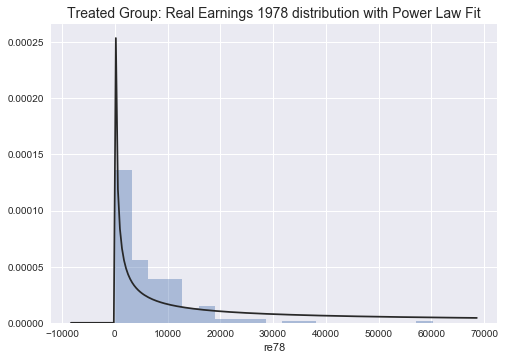

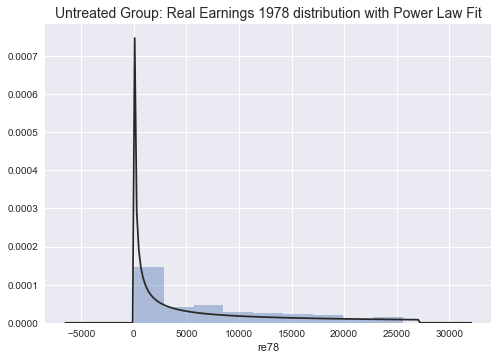

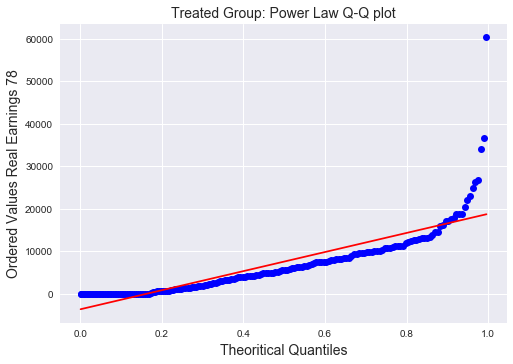

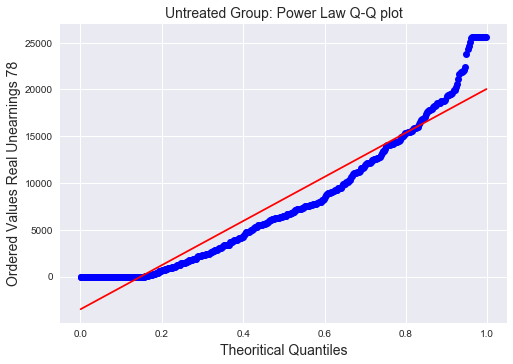

In [9]:
# check if the treated and untreated datasets fits the power distribution
sns.distplot(treated['re78'], fit=stats.powerlaw, kde=False)
plt.title('Treated Group: Real Earnings 1978 distribution with Power Law Fit',fontsize=14)
plt.show()

sns.distplot(untreated['re78'], fit=stats.powerlaw, kde=False)
plt.title('Untreated Group: Real Earnings 1978 distribution with Power Law Fit',fontsize=14)
plt.show()

# plot the Q-Q plots to see if there is a relationship
stats.probplot(treated['re78'], dist=stats.powerlaw, sparams=(0.8),plot=plt)
plt.title("Treated Group: Power Law Q-Q plot", fontsize=14)
plt.xlabel('Theoritical Quantiles', fontsize=14)
plt.ylabel('Ordered Values Real Earnings 78', fontsize=14)
plt.show()

stats.probplot(untreated['re78'], dist=stats.powerlaw, sparams=(0.8),plot=plt)
plt.title("Untreated Group: Power Law Q-Q plot", fontsize=14)
plt.xlabel('Theoritical Quantiles', fontsize=14)
plt.ylabel('Ordered Values Real Unearnings 78', fontsize=14)
plt.show()

From these plots, it is difficult to analyze these distributions because the Q-Q plots have many outliers.

Overall, we have made several naive conclusions from observing the numbers and distributions of the dataset. We have observed that the max salary is higher for the treated group and the number of people earning low income is high in the untreated group. These observations lead us to naively believe that the training program worked.

### 2. A closer look at the data
#### You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above. You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

#### For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

#### What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

Let's consider the distributions in the treated group and control groups first for the categorical features ('race', 'marriage status', and 'degree received or not') in the dataset first by using box plots.

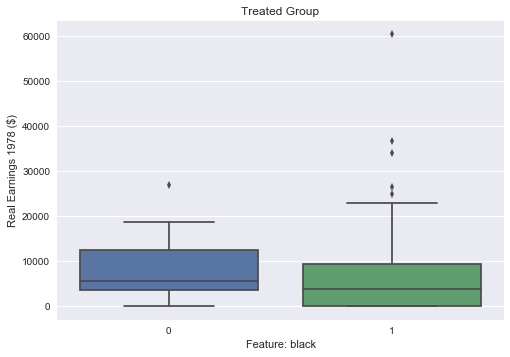

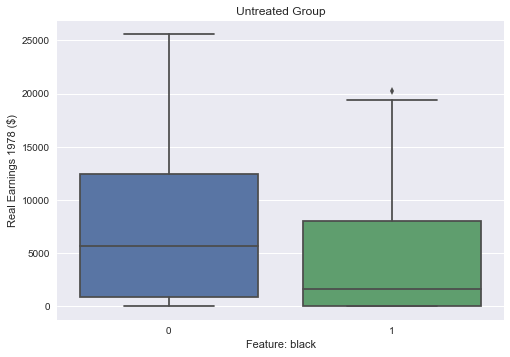

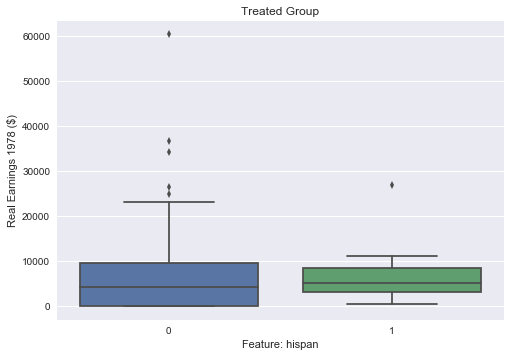

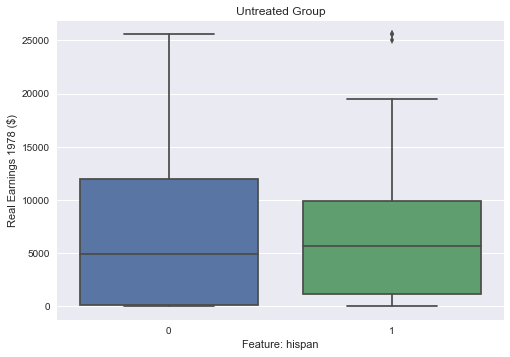

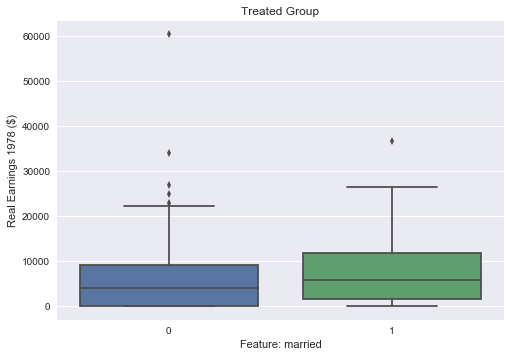

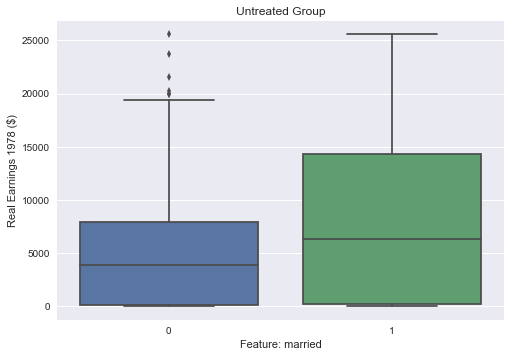

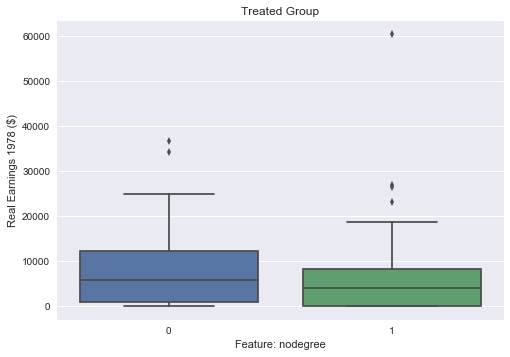

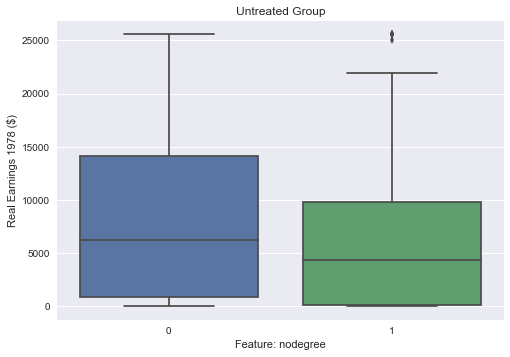

In [10]:
categorical_features = ['black', 'hispan', 'married', 'nodegree']

# create each box plot for each feature vs re78
for ft in categorical_features:
    sns.boxplot(x=ft, y="re78", data=treated)
    plt.title('Treated Group')
    plt.xlabel('Feature: ' + ft)
    plt.ylabel('Real Earnings 1978 ($)')
    plt.show()
    
    sns.boxplot(x=ft, y="re78", data=untreated)
    plt.title('Untreated Group')
    plt.xlabel('Feature: ' + ft)
    plt.ylabel('Real Earnings 1978 ($)')
    plt.show()

Now let's consider the features with continuous values using scatter plots:

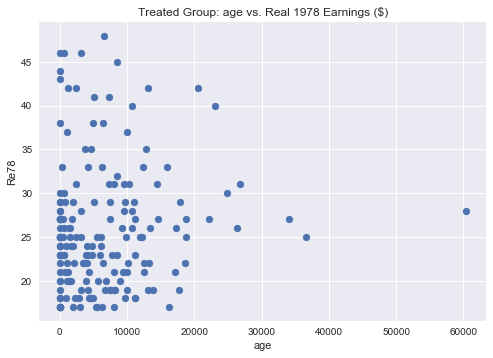

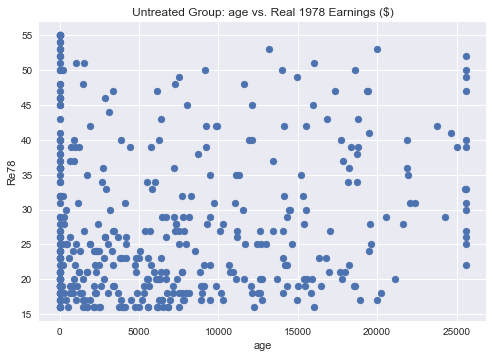

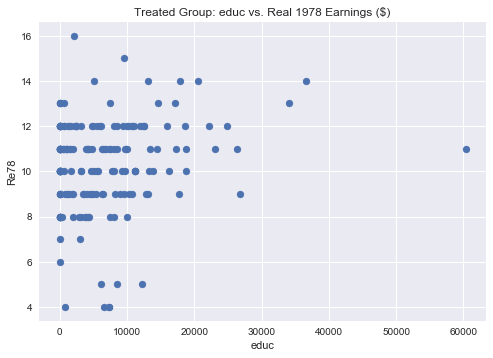

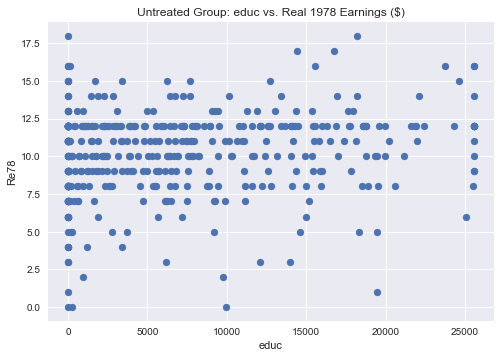

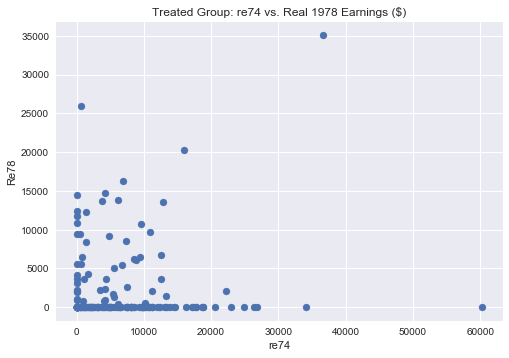

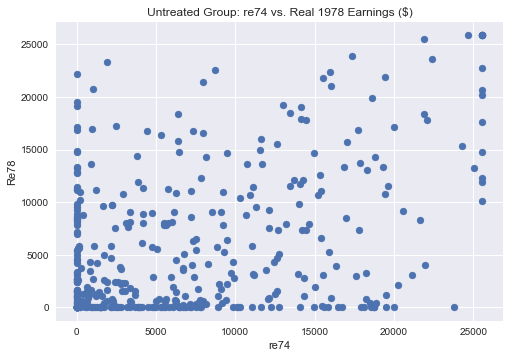

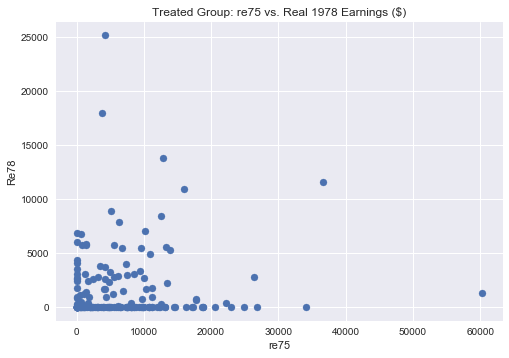

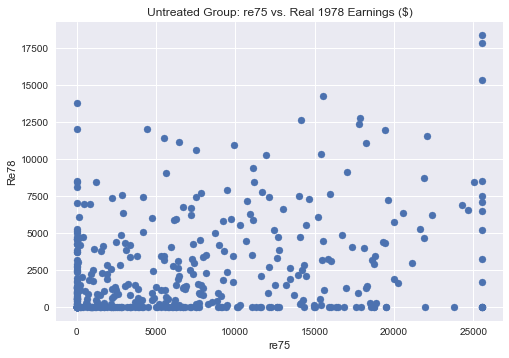

In [11]:
continous_features = ['age','educ','re74','re75']

# create a scatter plot for each feature vs re78
for ft in continous_features:
    plt.scatter(treated['re78'], treated[ft])
    plt.title('Treated Group: %s vs. Real 1978 Earnings ($)'%(ft))
    plt.xlabel(ft)
    plt.ylabel('Re78')
    plt.show()
    
    plt.scatter(untreated['re78'], untreated[ft])
    plt.title('Untreated Group: %s vs. Real 1978 Earnings ($)'%(ft))
    plt.xlabel(ft)
    plt.ylabel('Re78')
    plt.show()

We cannot find any linear correlations between the continuous features and the real earnings in 1978. Let's try another approach. Regarding education, we can try to split it into two categories: Pre-University and University Education.

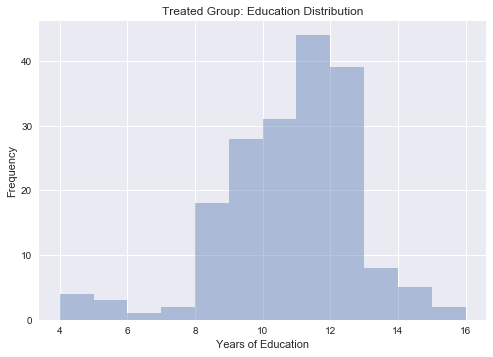

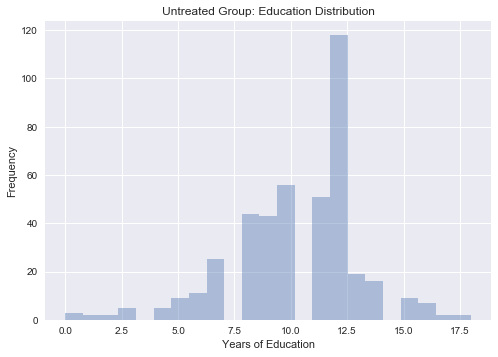

In [12]:
sns.distplot(treated['educ'], kde=False)
plt.xlabel('Years of Education')
plt.ylabel('Frequency')
plt.title('Treated Group: Education Distribution')
plt.show()

sns.distplot(untreated['educ'], kde=False)
plt.xlabel('Years of Education')
plt.ylabel('Frequency')
plt.title('Untreated Group: Education Distribution')
plt.show()

We can choose a threshold of 12 years of study, which roughly corresponds to the end of high school (assumption).

In [13]:
# create a new column identifying if the individual has satisfied the educaation threshold of 12 years
df['educ_thres12'] = 1
df.loc[df['educ'] < 12, 'educ_thres12'] = 0
df.loc[df['educ'] < 12, 'educ_thres12'] = 0

df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,educ_thres12
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0


Here we try basic statistical analysis. Since the data distribution is not normal and the number of samples is not very large, we can use a non parametric test.

In [14]:
# add the new variable to our categorical features list
categorical_features = categorical_features + ['educ_thres12']

Let's look at the influence of the categorical features and how they could bias our score.

In [15]:
# find the p-values for all of the covariates
for ft in categorical_features:
     print('covariate =', ft, ' ', stats.ranksums(df['re78'][df[ft]==1], df['re78'][df[ft]==0]))

covariate = black   RanksumsResult(statistic=-3.5868841633784352, pvalue=0.00033465289541746658)
covariate = hispan   RanksumsResult(statistic=0.90156565385238707, pvalue=0.36728764298738426)
covariate = married   RanksumsResult(statistic=3.2700394528267465, pvalue=0.0010753248556850177)
covariate = nodegree   RanksumsResult(statistic=-2.9165541847092897, pvalue=0.0035392124311496519)
covariate = educ_thres12   RanksumsResult(statistic=2.9165541847092897, pvalue=0.0035392124311496519)


In [16]:
# now we compare the outcome given the treatment: 
print('Effect of the treatment:', stats.ranksums(treated['re78'], untreated['re78']))

Effect of the treatment: RanksumsResult(statistic=-1.0697674002995952, pvalue=0.28472401948773163)


### Conclusion: 
At a significance level or p-value of 0.05, it seems that the African-American origin, married status, education degree (or abscence of it), and education threshold have an influence on the salary of the participants. However the job training program (treat) has no significant effect!

### 3. A propensity score model

#### Use logistic regression to estimate propensity scores for all points in the dataset. You may use sklearn to fit the logistic regression model and apply it to each data point to obtain propensity scores. Note: you do not need a train/test split here. Train and apply the model on the entire dataset. 

Here, we want to train a logistic regression model using the entire dataset with x = covariates and y = treatment.  

In [17]:
covariates = df[['age','educ','black','hispan','married','nodegree','re74','re75']]
fn = linear_model.LogisticRegression()

# predict_proba returns the probability of the sample for each class in the model, where classes are ordered as they are in self.classes_.
logistic = fn.fit(covariates, df.treat.ravel()) 
propensity_score = fn.predict_proba(covariates)[:,1] 

In [18]:
# append the score to the table
df['propensity_score'] = propensity_score
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,educ_thres12,propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0,0.698286


The propensity score identifies the chance that the person is in the treated/job-training group. For example, person NSW4 has a 66.4% chance of being in the treated group.

We want to the model with the whole training set to get logistic regression model with x=covariates and y= treatment  

### 4. Balancing the dataset via matching

#### Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. (Hint: you may explore the networkx package in Python for predefined matching functions.)

#### Your matching should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

#### After matching, you have as many treated as you have control subjects. Compare the outcomes (re78) between the two groups (treated and control).

#### Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects. What do you observe? Are you closer to being able to draw valid conclusions now than you were before?

In [19]:
untreated_propensity = df[df['treat'] == 0]['propensity_score']
treated_propensity = df[df['treat'] == 1]['propensity_score']

In [20]:
# get the index of the redundant values that we can match together
def matches(l1, l2):
    common1=[]
    common2=[]
    for i_idx, i in enumerate(list(l1)):
        for j_idx, j in enumerate(list(l2)):
            if i==j:
                common1.append(i_idx)
                common2.append(j_idx)
    return common1, common2

common1, common2 = matches(untreated_propensity, treated_propensity)

# remove the commun values
untreated_nonshared = [i for i in np.arange(len(untreated_propensity)) if i not in common1]
treated_nonshared=[i for i in np.arange(len(treated_propensity)) if i not in common2]

untreated_propensity = untreated_propensity.iloc[untreated_nonshared]
treated_propensity = treated_propensity.iloc[treated_nonshared]

In [21]:
# create graph 
G = nx.Graph()

# create nodes
G.add_nodes_from(list(untreated_propensity), bipartite=1)
G.add_nodes_from(list(treated_propensity), bipartite=0)

# create edges and add them 
edges = list(itertools.product(list(untreated_propensity), list(treated_propensity)))
weighted_edge = [(x[0], x[1], 1-np.abs(x[1]-x[0])) for x in edges]
G.add_weighted_edges_from(weighted_edge)

# verify that the graph is connected
print(nx.is_connected(G))
# l, r = nx.bipartite.sets(B)

# perform matching 
max_matching = nx.max_weight_matching(G, maxcardinality=False)

True


In [22]:
# get index of unique pair of matches in "data"
match_idx = [(df[df['propensity_score']==key].index[0], df[df['propensity_score']==value].index[0])  for key, value in max_matching.items()]
# sort the pairs of matches
match_idx_sorted = [sorted(i) for i in match_idx]
# get unique matches
match_idx_unique = [match_idx_sorted[i] for i in range(len(match_idx_sorted)) if i%2 == 1]
print('Number of unique matches: ' + str(len(match_idx_unique)))

Number of unique matches: 155


In [23]:
# create a new column with the pair id
for i in range(len(match_idx_unique)):
        df.loc[match_idx_unique[i][0],'pair_matching'] = i+1 # start at 1, FIRST ITEM OF PAIR 
        df.loc[match_idx_unique[i][1],'pair_matching'] = i+1 # SECOND ITEM OF PAIR

In [24]:
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,educ_thres12,propensity_score,pair_matching
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0,0.443350,99.0
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0,0.144660,58.0
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1,0.722355,37.0
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0,0.664151,31.0
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0,0.698286,7.0


Now, we will try to see if there is a difference of real earnings in 1978 between the treated and control matches.
1. We will compute the difference of income between the two groups.
2. We will perform a one sample t-test to determine we can reject the hypothesis "H0 : Difference = 0".

In [25]:
# compute the difference between two matched pairs
df['Re78_diff_pair'] = 0

for i in match_idx_unique:
    # first item of the pair is a control subject
    if df.loc[i[0],'treat']==0: 
        df.loc[i[0],'Re78_diff_pair'] = df.loc[i[1],'re78'] - df.loc[i[0],'re78'] 
    #  first item of the pair is a treated subject   
    else: 
        df.loc[i[1],'Re78_diff_pair']=df.loc[i[0],'re78'] - df.loc[i[1],'re78']

In [26]:
# perform the t-test
diff_df = pd.DataFrame(df.loc[:,'Re78_diff_pair'][df['treat']==0])
true_diff = 0

onesample_results = stats.ttest_1samp(diff_df, true_diff)
onesample_results

Ttest_1sampResult(statistic=array([ 1.62211469]), pvalue=array([ 0.10551515]))

Here we can see that the difference is significant at the 0.05 level. But the p-value is not very small. E.g. It is not significant at 0.01 level.

Now after matcing we will check that the groups have similar distributions for their covariates.

In [27]:
# suppress non matched samples from dataframe
df_pairs = df[df['pair_matching'] != 0]

Compare the mean and the standard error of each covariate in the matched group:

In [28]:
data_covariates = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree','re74', 're75']

In [29]:
def check_balanced(data, covariatei):
    '''Look at each covariate and compute mean difference as well as standard error'''
    means = data[covariatei].groupby(data['treat']).mean()
    dist = abs(means.diff()).loc[1]
    s = data[covariatei].groupby(data['treat']).std()
    n = data['treat'].value_counts()
    se = np.sqrt(s[0]**2/n[0] + s[1]**2/n[1])
    return dist, se

In [30]:
# compare mean and standard error in the matched dataset for the covariates
for i in data_covariates:
    dist, SE = check_balanced(df_pairs, i)
    print("For covariate '{}' the distance of the means is {} and the standard error is {}".\
          format(i,round(dist*100)/100,round(SE*100)/100))

For covariate 'age' the distance of the means is 2.21 and the standard error is 0.74
For covariate 'educ' the distance of the means is 0.11 and the standard error is 0.2
For covariate 'black' the distance of the means is 0.64 and the standard error is 0.03
For covariate 'hispan' the distance of the means is 0.08 and the standard error is 0.02
For covariate 'married' the distance of the means is 0.32 and the standard error is 0.04
For covariate 'nodegree' the distance of the means is 0.11 and the standard error is 0.04
For covariate 're74' the distance of the means is 3523.66 and the standard error is 486.32
For covariate 're75' the distance of the means is 934.43 and the standard error is 285.1


Here we can see that the covariate 're74' is clearly unbalanced and 're75' is also sligtly unbalanced.

It can be also really interesting to compare the pre and the post matching distrbutions for each of the covariates.

In [7]:
def plot(post, pre, covariatei):
    '''Plot the distribution of covariates before and after matching'''
    plt.figure(1)

    plt.subplot(1,2,1)
    densityCont_pre = stats.gaussian_kde(post[covariatei][pre['treat']==0])
    densityTreat_pre = stats.gaussian_kde(pre[covariatei][pre['treat']==1])
    control=sns.distplot(pre[covariatei][pre['treat']==0],rug=True,kde=True,hist=False, color='m',label= 'Control Group')
    treated=sns.distplot(pre[covariatei][pre['treat']==1],rug=True,kde=True,hist=False, color='g',label= 'Treated Group')
    plt.title('Pre - Matching')
    plt.xlabel(covariatei)
    plt.ylabel('Distribution')        
    #plt.legend(['Control Group', 'Treated Group'])
    

    plt.subplot(1,2,2)
    control=sns.distplot(post[covariatei][post['treat']==0],rug=True,kde=True,hist=False, color='r',label= 'Control Group')
    treated=sns.distplot(post[covariatei][post['treat']==1],rug=True,kde=True,hist=False, color='b',label= 'Treated Group')
    plt.title('Post - Matching')
    plt.xlabel(covariatei)
    plt.ylabel('Distribution')
    #plt.legend(['Control Group', 'Treated Group'])
    
    plt.show()
    plt.show()  

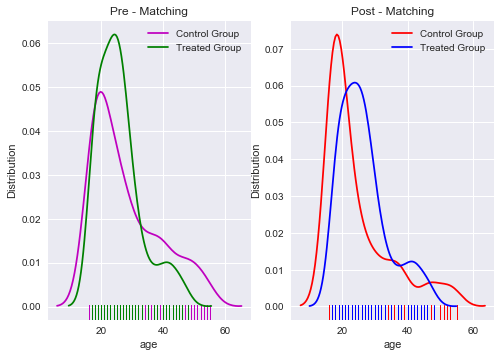

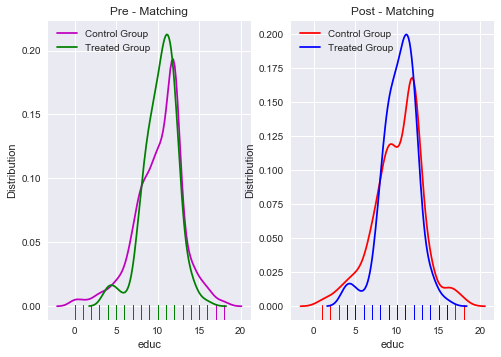

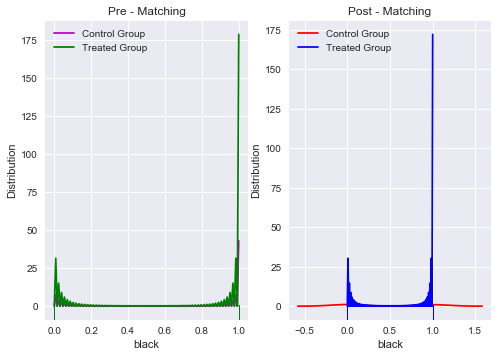

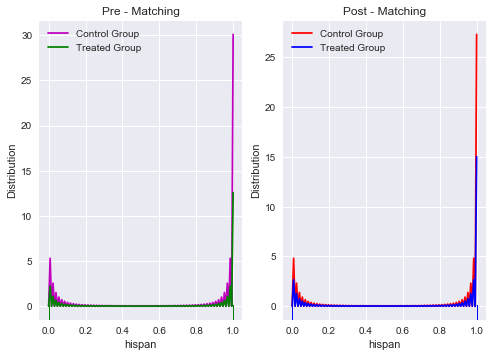

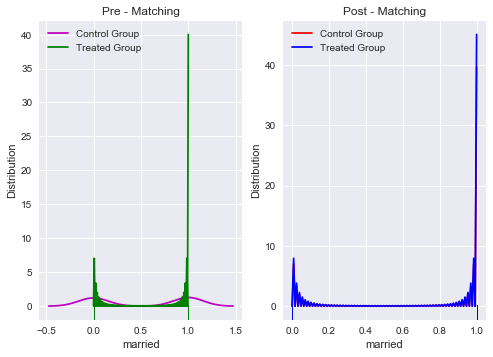

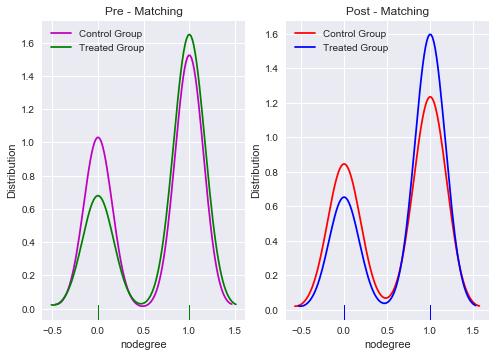

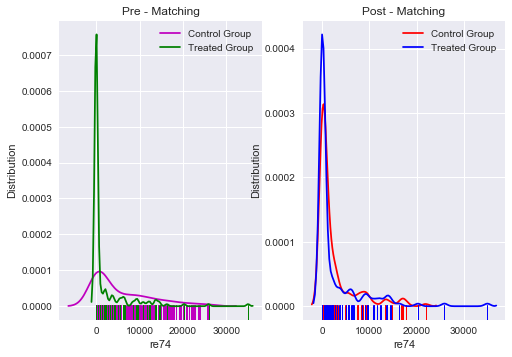

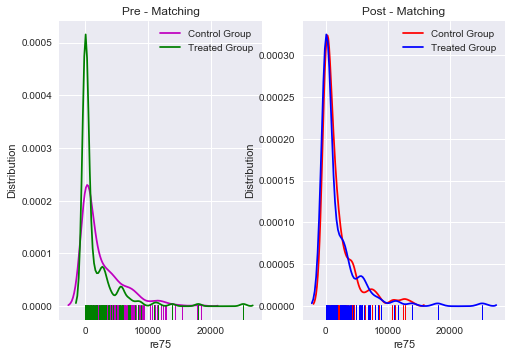

In [449]:
for i in data_covariate:
    plot(df_pairs, df, i)

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

### Part 1

Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn (link).
TF-IDF, short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using TfidfVectorizer. Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

### Load the 20newsgroups dataset using scikit

In [30]:
import itertools
from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.csr import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from pprint import pprint

In [10]:
newsgroups_train = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))

print("Found {} categories in data".format(len(newsgroups_train.target_names)))
pprint(list(newsgroups_train.target_names))

print("Found {} filenames in data".format(newsgroups_train.filenames.shape))
print("Found {} targets in data". format(newsgroups_train.target.shape))

Found 20 categories in data
['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
Found (11314,) filenames in data
Found (11314,) targets in data


### Vectorize all the given data using the TF-IDF Vectorizer

In [11]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)

print("Converted text into vectors of shape {}".format(vectors.shape))

Converted text into vectors of shape (11314, 101631)


### The vectors using the vectorizer are sparse and have an average of 97 non-zero components by sample.

In [12]:
print("Number of non-zero components by sample is {}".format(vectors.nnz / float(vectors.shape[0])))

Number of non-zero components by sample is 97.54525366802191


### Before we split the data, we need to pair each label with its corresponding label (the article category).

In [13]:
# create a dictionary mapping from category name to index in the list target_names
category_indices = dict()
for index, key in enumerate(newsgroups_train.target_names):
    category_indices[key] = index

pprint(category_indices)

{'alt.atheism': 0,
 'comp.graphics': 1,
 'comp.os.ms-windows.misc': 2,
 'comp.sys.ibm.pc.hardware': 3,
 'comp.sys.mac.hardware': 4,
 'comp.windows.x': 5,
 'misc.forsale': 6,
 'rec.autos': 7,
 'rec.motorcycles': 8,
 'rec.sport.baseball': 9,
 'rec.sport.hockey': 10,
 'sci.crypt': 11,
 'sci.electronics': 12,
 'sci.med': 13,
 'sci.space': 14,
 'soc.religion.christian': 15,
 'talk.politics.guns': 16,
 'talk.politics.mideast': 17,
 'talk.politics.misc': 18,
 'talk.religion.misc': 19}


In [21]:
# returns the index of the category based on the name extracted from file
def get_category(filenames):
    # for each filename, split by slash and take the filename field which is at index 6
    fields = []
    for filename in filenames:
        field = filename.split("/")[6]
        category_index = category_indices[field]
        fields.append(category_index)
    # return all the fields as a list
    return fields

# get all the corresponding indices for each filename
fields = np.array(get_category(newsgroups_train.filenames))

# create a matrix
category = np.transpose(csr_matrix(fields))
print(fields)

[7 4 4 ..., 3 1 8]


### Split the data into a testing, a validation, and a training set.

In [25]:
# vectors is our x data and targets is our y data
x = vectors
y = newsgroups_train.target

# data_points is the number of rows in x and y data
DATA_POINTS = y.shape[0]

# constants for size of 3 kinds of split datasets
TEST_SIZE = 0.1
VALIDATION_SIZE = 0.1
TRAIN_SIZE = 0.8

indices = list(range(DATA_POINTS))
shuffle(indices)

# calculate range of indices for each of the 3 split datasets
test_range = indices[:int(TEST_SIZE * DATA_POINTS)]
validation_range = indices[int(TEST_SIZE * DATA_POINTS) : int(TEST_SIZE*2 *DATA_POINTS)]
train_range = indices[int(TEST_SIZE*2 *DATA_POINTS):]

x_test = x[test_range]
y_test = y[test_range]

x_validation = x[validation_range]
y_validation = y[validation_range]

x_train = x[train_range]
y_train = y[train_range]

print("Shape of original x and y datasets = {} and {}".format(x.shape, y.shape))
print("Shape of testing x and y datasets = {} and {}".format(x_test.shape, y_test.shape))
print("Shape of validation x and y datasets = {} and {}".format(x_validation.shape, y_validation.shape))
print("Shape of training x and y datasets = {} and {}".format(x_train.shape, y_train.shape))

Shape of original x and y datasets = (11314, 101631) and (11314,)
Shape of testing x and y datasets = (1131, 101631) and (1131,)
Shape of validation x and y datasets = (1131, 101631) and (1131,)
Shape of training x and y datasets = (9052, 101631) and (9052,)


### Part 2

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the *feature\_importances\_* attribute of your random forest and discuss the obtained results.

### Grid search on the number of estimators and the max depth of the trees

In [ ]:
# best is a dictionary storing all the parameters which give the highest accuracy
best = dict()
best["accuracy"] = 0
best["n_estimators"] = 0
best["max_depth"] = 0

# grid search on the given ranges of n_estimators and max_depth
for n_estimators in range(100, 501, 100):
    for max_depth in range(100, 501, 100):
        # train random forest model using training datasets
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
        clf.fit(x_train, y_train)
        
        # calculate accuracy on validation datasets
        accuracy = accuracy_score(y_validation, clf.predict(x_validation))
        
        # if current accuracy is higher than the highest so far, print
        if accuracy > best["accuracy"]:
            best["n_estimators"] = n_estimators
            best["max_depth"] = max_depth
            best["accuracy"] = accuracy
#             print("Better params found: n_estimators = {} max_depth = {} accuracy = {}"
#                   .format(n_estimators, max_depth, accuracy))

#### On running the above Grid search, we found the best n_estimator to be 300 and the max_depth to be 310

Here are some of the saved results so we don't have to run the grid search again

1. Better params found: n_estimators = 100 max_depth = 10 accuracy = 0.5508399646330681
2. Better params found: n_estimators = 100 max_depth = 110 accuracy = 0.632183908045977
3. Better params found: n_estimators = 100 max_depth = 210 accuracy = 0.6419098143236074
4. Better params found: n_estimators = 200 max_depth = 110 accuracy = 0.6569407603890363
5. Better params found: n_estimators = 300 max_depth = 110 accuracy = 0.6578249336870027
6. Better params found: n_estimators = 300 max_depth = 210 accuracy = 0.6657824933687002
7. Better params found: n_estimators = 300 max_depth = 310 accuracy = 0.6666666666666666

### Print best n_estimators and max_depth found

In [ ]:
# finally printing the best parameters and the highest accuracy
print("Best accuracy found for params: n_estimators = {} max_depth = {} accuracy = {}"
      .format(best["n_estimators"],
              best["max_depth"],
              best["accuracy"]
             ))

### Check accuracy on testing dataset using best parameters to avoid overfitting

In [26]:
# run model using the best parameters
clf = RandomForestClassifier(n_estimators=300, max_depth=310, n_jobs=-1)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# calculate accuracy on testing dataset
test_accuracy = accuracy_score(y_test, y_pred)

print("Accuracy on testing data = {}".format(test_accuracy))

Accuracy on testing data = 0.6604774535809018
Using params: n_estimators = 0 max_depth = 0 accuracy = 0


### Plot Confusion Matrix

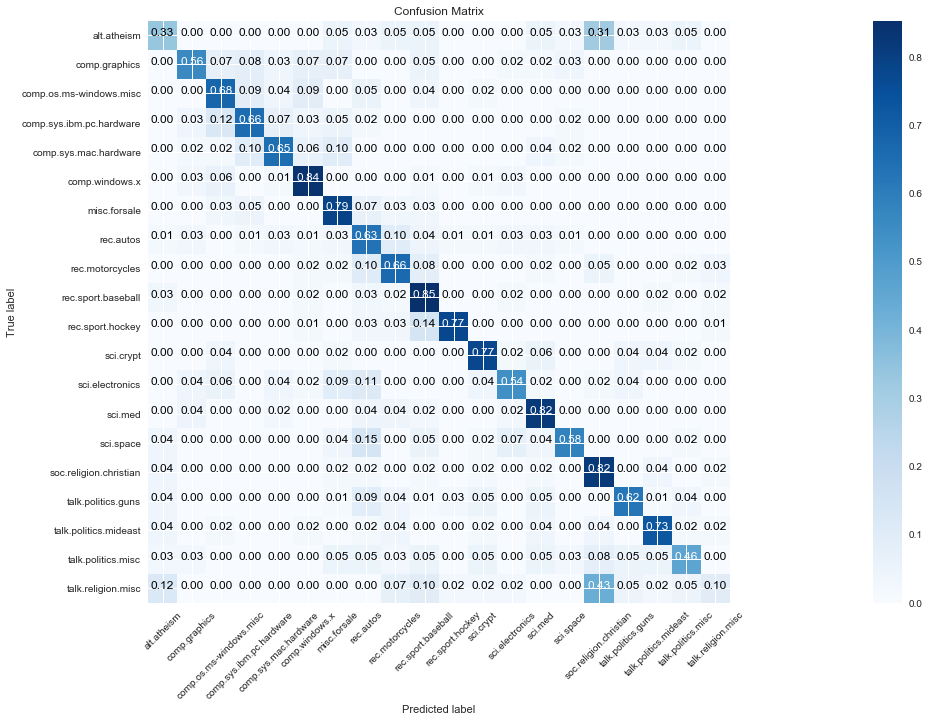

In [34]:
# we plot the confusion matrix here
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(40, 10))

cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(list(newsgroups_train.target_names)))
plt.xticks(tick_marks, list(newsgroups_train.target_names), rotation=45)
plt.yticks(tick_marks, list(newsgroups_train.target_names))

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()
plt.savefig("Confusion_Matrix.png")

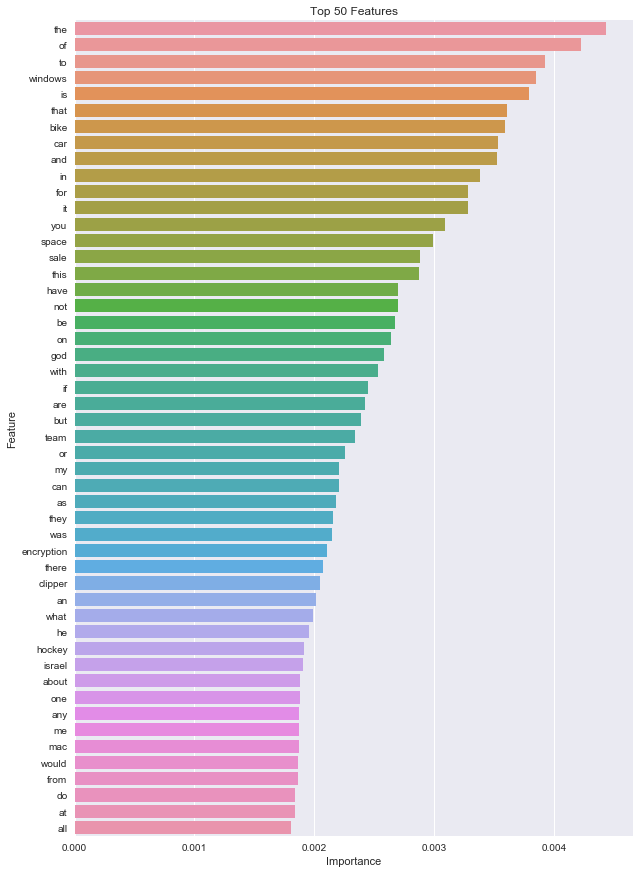

In [41]:
plt.figure(figsize=(10, 15))
features = vectorizer.get_feature_names()

sorted_features = np.array(
                           sorted(zip(
                                clf.feature_importances_.astype(np.float64),
                                features)
                           ))[::-1]

ax = sns.barplot(
        x=sorted_features[:50][:, 0].astype(np.float64),
        y=sorted_features[:50][:, 1])

ax.set_title("Top 50 Features")
ax.set_ylabel("Feature")
ax.set_xlabel("Importance")

plt.show()
plt.savefig("Top_50_Features.png")